# Data science hire - take home project

Xylo Systems has been asked to develop a report for the international development company, Lendlease. They currently have a brownfield project site in the Western Sydney suburb of Schofields that they want a baseline biodiversity assessment for. This report will inform how they design their development to optimise biodiversity and will be used to track their impact on biodiversity as part of the company’s nature positive strategy. Below are some of the questions/requests they want to addressed in the report:

- Is the biodiversity in this area endangered? To what degree?
- What are the biggest risks to biodiversity in the area?
- Which biodiversity class is the most endangered?
- How might habitat loss change the biodiversity in this area?
- Calculate a biodiversity index/metric that communicates the state of biodiversity in a single number (explain your working and any sources you may have used to build this)


### Ninz approach

- Identify and clean data sources
- Read about biodiversity and try to understand the following
    - Factors that affect biodiversity
    - How biodiversity is changing and why is it changing?
    - What are the relationships we can extract from other data sources that can provide insight to the biodiversity of a certain ecosystem.
- Break down the questions/project requirements into simpler task
- Identify what information I can extract and use to create a **simple** and straight forward presentation.

Coming into this challenge, I have two things in my mind.

- I am not a biodiversity expert, but so does most client/partners that would want to use the system. So the idea is to create simple and straight forward data insights that non-biodiversity experts can easily understand.
- Honestly speaking, I am not good at visuals and design. So my graphs and other visualisation might not look good. To overcome this, I am thinking of relying on using data comparisions, cause and effect, and other similar data presentation techniques.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from dataclasses import dataclass
from scipy.interpolate import interp1d
from scipy.misc import derivative

## Data sources

I mainly use the data obtained from the following sources
- For the geofenced species data https://doi.ala.org.au/doi/10.26197/ala.d5ed3ad0-cea4-40f0-b96e-91dca266d35b
- For the conservation status data https://www.iucnredlist.org/

In [2]:
species_data = pd.read_csv("data/schofield_radius_5_.csv", low_memory=False)
conservation_data = pd.read_csv("data/endanged_assessment.csv")

In [3]:
# UTILITY FUNCTIONS
def get_date_bounded(df, start_date, end_date):
    """Filters the data with the given date range"""

    mask = (df.date_clean > start_date) & (df.date_clean <= end_date)
    bounded_df = df[mask]
    return bounded_df

def show_historical_graph_per_species(df, top=10, title=""):
    """Show historical record of top N species data"""
    # IMPOTANT NOTE
    # individualCount - only represents visual observation. Sound observations can also be made
    plt.figure(figsize=(10,4))
    top_species = df.species.value_counts()[:top].index
    for spc in top_species:
        agg = df[df.species == spc].groupby(df.date_clean.dt.year)['final_count'].sum()
        plt.plot(agg.index, agg.values, label=spc)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
def get_trend(data) -> int:
    """
    Takes in a series of data and identify downtrend or uptrend.
    
    + trend goes up
    - trend goes down
    = no movement
    Used this calculation to see min/max trend
    https://stackoverflow.com/a/71694447/3998151
    """
    x = range(len(data))
    
    f = interp1d(x, data, fill_value="extrapolate")
    x_fake = np.arange(1.1, len(data)-1, 0.1)

    # derivative of y with respect to x
    df_dx = derivative(f, x_fake, dx=1e-6)
    average = np.average(df_dx)
    # overall measure: ((np.max(df_dx))-np.min(df_dx)-average)/((np.max(df_dx))-np.min(df_dx))
    # print(f"trend min: {np.min(df_dx)} max: {np.max(df_dx)}, average: {average}")
    # Downtrend
#     if average < 0:
#         # Plot
#         fig = plt.figure()
#         ax1 = fig.add_subplot(211)
#         ax2 = fig.add_subplot(212)

#         ax1.errorbar(x, data, fmt="o", color="blue", label='Input data')
#         ax1.errorbar(x_fake, f(x_fake), label="Interpolated data", lw=2)
#         ax1.set_xlabel("x")
#         ax1.set_ylabel("y")

#         ax2.errorbar(x_fake, df_dx, lw=2)
#         ax2.errorbar(x_fake, np.array([0 for i in x_fake]), ls="--", lw=2)
#         ax2.set_xlabel("x")
#         ax2.set_ylabel("dy/dx")

    return average

def transform_with_conservation_status(df, years_threshold:int = 5):
    """
    Creates a new dataframe with conservation status
    and taxonomy information
    
    years_threshold - number of years to be considered included in calculation
    
    New dataframe should include:
    - species
    - phylum
    - class
    - order
    - family
    - genus
    - computed_trend: computed from the species table
    - sufficient_local_data: bool
    - conservation_status
    - assessment_date
    - population_trend
    - possibly_extinct: bool
    - possibly_extinct_in_wild: bool
    """
    columns = ["species", "phylum", "class", "order", "family", "genus",
               "computed_trend", "sufficient_local_data", "conservation_status",
               "assessment_date", "population_trend", "possibly_extinct",
               "possibly_extinct_in_wild"]
    
    cols = ["phylum", "class", "order", "family", "genus"]
    
    df_list = []
    species = df.species.unique()

    for specie in species:
        if not isinstance(specie, str):
            continue
        temp_list = []
        taxon = df[df.species == specie][cols].iloc[0].values
        temp_list = [specie] + list(taxon)
        
        yoy_data = df[df.species == specie].set_index("date_clean").resample("Y", convention="end")["final_count"].sum()
        
        # Assign computed trend if enough years
        if len(yoy_data.values) <= years_threshold:
            temp_list += [0, False]
        else:
            temp_list += [get_trend(yoy_data.values), True]
            
        # Assign conservation status data if there is any
        if specie not in conservation_status_map:
            temp_list += ["no data", None, None, None, None]
        else:
            temp_list += [
                conservation_status_map[specie].category,
                conservation_status_map[specie].assessment_date,
                conservation_status_map[specie].population_trend,
                conservation_status_map[specie].possibly_extinct,
                conservation_status_map[specie].possibly_extinct_in_wild
            ]
        df_list.append(temp_list)
            
            
    return pd.DataFrame(df_list, columns=columns)

def show_conservation_data(df, title="Animals"):
    """
    Display some conservation status data per species
    """
    # Source https://australian.museum/learn/animals/conservation-status-what-does-it-mean/
    threatened_status = ["Vulnerable", "Endangered", "Critically Endangered"]
    df1 = df.species.groupby(df.conservation_status).count().reset_index(name='count').sort_values(['count'], ascending=False)
    df2 = df[["species", "computed_trend", "population_trend", "conservation_status"]][df.conservation_status.isin(threatened_status)].sort_values(["conservation_status", "computed_trend"])
    
    display(HTML(f"<h2>Conservation Distribution [{title}]</h4>"))
    display(df1)
    display(HTML(f"<h2>Species that belong to threatened status [{title}]</h4>"))
    display(df2)

#### Quick cleanup
- Just remove columns that contains null values for all data points
- Check columns that contain only one unique value, see if they can be removed
- Add a proper datetime column for easier filters

***ASSUMPTION***: The individualCount column seems to represent only visual events. There are other columns that has NaN values but contain other type of events, e.g. sound, etc. Just assign 1 for these events. Create a final_count col just to be sure.

For the endangered data
- Transform it an hashmap for easier access, ideally we have a database lookup for this
- Drop some columns that might not be needed

In [4]:
@dataclass
class ConservationStatus:
    """
    I have a habit of using dataclasses
    """
    scientific_name: str
    category: str
    assessment_date: datetime.datetime
    population_trend: str
    possibly_extinct: bool
    possibly_extinct_in_wild: bool    

        
def clean_species_data(df):
    """
    Apply some basic data cleaning on species data
    """
    empty_cols = []
    for c in df.columns:
        if df[c].isnull().values.all():
            empty_cols.append(c)

    # Drop columns with all empty values
    data_without_empty = df.drop(empty_cols, axis=1)

    # Check columns with only one value, see if they can all be removed
    cols_with_one_value = []
    for c in data_without_empty.columns:
        if data_without_empty[c].nunique() == 1:
            cols_with_one_value.append(c)

    cleaned_data = data_without_empty.drop(cols_with_one_value, axis=1)        
    cleaned_data["date_clean"] = pd.to_datetime(cleaned_data.eventDate)
    cleaned_data["final_count"] = cleaned_data.individualCount.fillna(1)
    
    return cleaned_data


def transform_to_hash_map(df):
    """
    Transforms the endagered dataset to hashmap for easier access.
    Will retain the following properties.
    - scientificName
    - redlistCategory
    - assessmentDate
    - populationTrend
    - possiblyExtinct
    - possiblyExtinctInTheWild
    """
    
    species_map = {}
    
    df["assessmentDate"] = pd.to_datetime(df.assessmentDate)
    for _, row in df.iterrows():
        species_map[row["scientificName"]] = ConservationStatus(
            scientific_name = row["scientificName"],
            category = row["redlistCategory"],
            assessment_date = row["assessmentDate"],
            population_trend = row["populationTrend"],
            possibly_extinct = row["possiblyExtinct"],
            possibly_extinct_in_wild = row["possiblyExtinctInTheWild"]
        )
    
    return species_map

In [5]:
# Load the useable dataset
conservation_status_map = transform_to_hash_map(conservation_data)
cleaned_data = clean_species_data(species_data)

#### Split the dataset

When I looked at the dataset, I noticed that plants and animal dataset is the majority of all the data. I decided to split the dataset since
- The other data from other kingdom only contains very few dataset
- It might be good to look at this on a per kingdom level as there might be some different insights that can be derived from it.
- We might be able to deduce a more specific plan of action/recommendation

***ASSUMPTION***: To simplify, I will just use the species field as a unique identifier

In [6]:
plant_data = cleaned_data[cleaned_data.kingdom == "Plantae"]
animal_data = cleaned_data[cleaned_data.kingdom == "Animalia"]
# fungi_data = cleaned_data[cleaned_data.kingdom == "Fungi"]

## Is the biodiversity in this area endangered? To what degree?

In order to answer this, I broke it down to the following
- Identify the different conservation status of the species
- Using the geofenced data, try to understand if there is an up/down trend of observed population in the area

Here are some assumptions that I had to make:
- Assume that the conservation status dataset still holds true to this date. Some of the data was recorded a few years back and conservation efforts might have change the trend for an organism.
- According to [National Geographic](https://education.nationalgeographic.org/resource/endangered-species/), population decline is measured in 10 years (3 generations) so I will use 10 year intervals when selecting a date range.

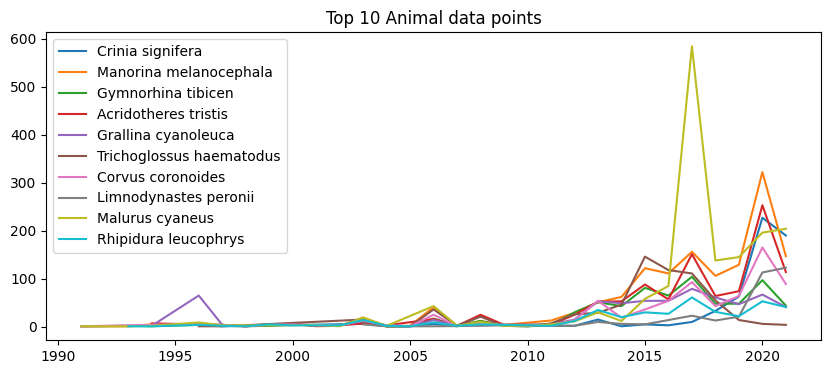

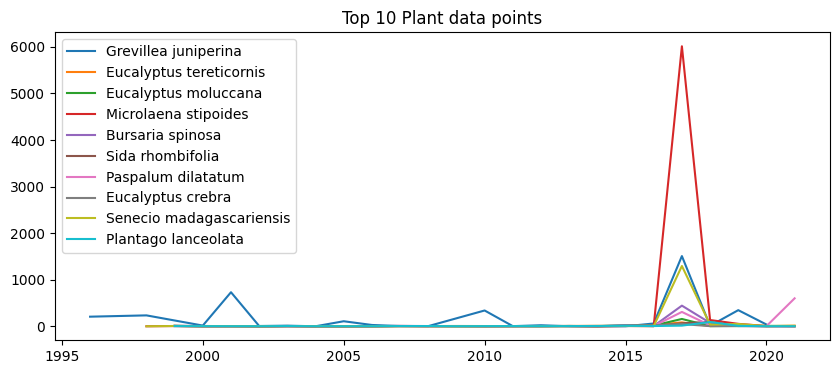

In [7]:
# Lets look into a 20 year interval
start_date = "1991-1-1"
end_date = "2021-12-31"

animal_bounded = get_date_bounded(animal_data, start_date, end_date)
plant_bounded = get_date_bounded(plant_data, start_date, end_date)
show_historical_graph_per_species(animal_bounded, 10, "Top 10 Animal data points")
show_historical_graph_per_species(plant_bounded, 10, "Top 10 Plant data points")

- Looking into the dataset, it is quite clear that the datapoints increased throughout the 20 year period.
- The increase in datapoints does not necessarily mean that more organisms are thriving. It can be attributed to the improve data collection and other factors that allow us to gather more observations.

**Australia Conservation Strategy**

Around 2010, the data collection seems to ramp up. One notable events during that time is the release of Australia's Biodiversity Conservation Strategy 2010-2030.
https://www.dcceew.gov.au/environment/biodiversity/conservation/strategy

In [8]:
ac_df = transform_with_conservation_status(animal_bounded)
pc_df = transform_with_conservation_status(plant_bounded)

In [9]:
show_conservation_data(ac_df)
show_conservation_data(pc_df, "Plants")

,conservation_status,count
3,Least Concern,289
6,no data,204
5,Vulnerable,9
4,Near Threatened,6
0,Critically Endangered,2
1,Data Deficient,1
2,Endangered,1


,species,computed_trend,population_trend,conservation_status
337,Anthochaera phrygia,-0.640449,Decreasing,Critically Endangered
29,Lathamus discolor,0.165939,Decreasing,Critically Endangered
330,Rostratula australis,0.000000,Decreasing,Endangered
268,Calidris acuminata,-14.031646,Decreasing,Vulnerable
440,Phascolarctos cinereus,0.000000,Decreasing,Vulnerable
492,Callocephalon fimbriatum,0.000000,Decreasing,Vulnerable
500,Heleioporus australiacus,0.000000,Decreasing,Vulnerable
1,Pteropus poliocephalus,0.083682,Decreasing,Vulnerable
432,Falsistrellus tasmaniensis,0.127517,Decreasing,Vulnerable
441,Litoria aurea,0.143216,Decreasing,Vulnerable


,conservation_status,count
5,no data,908
2,Least Concern,80
3,Near Threatened,8
4,Vulnerable,3
1,Endangered,2
0,Data Deficient,1


,species,computed_trend,population_trend,conservation_status
52,Persoonia hirsuta,0.000000,Decreasing,Endangered
916,Macrozamia spiralis,0.000000,Decreasing,Endangered
657,Eucalyptus baueriana,0.000000,Decreasing,Vulnerable
160,Eucalyptus longifolia,0.079498,Decreasing,Vulnerable
176,Eucalyptus moluccana,0.239234,Stable,Vulnerable
